<div style="text-align: center;">
    <h1><strong>PyTorch Fundamentals -- My Notes</strong></h1>
</div>

### Imports

In [ ]:
# Vast
# !pip install matplotlib
# !pip install scikit-learn

# Import PyTorch
import torch

import torch.nn.functional as F
from torch import nn # Neural network module with loss functions, layers and container modules
from torch.utils.data import DataLoader # Load and batch data using this
from torch.optim.lr_scheduler import ReduceLROnPlateau # Scheduler

# Import torchvision
import torchvision

from torchvision.datasets import ImageFolder # to use custom datasets
from torchvision import transforms # get functions for manipulating your vision data here
from torchvision.transforms import ToTensor # convert a PIL image of numpy array to tensor using this

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Other imports
import os
import numpy as np
from pathlib import Path
from timeit import default_timer as timer
import csv
from sklearn.metrics import confusion_matrix

# Check versions
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

# Check if CUDA is available
print(f"\nCUDA Available: {torch.cuda.is_available()}")

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
gpu = torch.cuda.get_device_name(0)
print(f"GPU: {gpu}")


PyTorch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121

CUDA Available: True
GPU: NVIDIA GeForce RTX 4090


### Vast

In [ ]:
# import zipfile

# zip_path = r"EuroSATsplit.zip"
# extract_path = r"data/EuroSATsplit"

# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall(extract_path)

# print(os.listdir(extract_path))

['test', 'train']


#### Load saved values

### Data transformation & Inspection

In [10]:
# Define transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3444, 0.3803, 0.4078], std=[0.2027, 0.1369, 0.1155])
])

# Define paths
# TRAIN_PATH = r"C:/Users/aquas/Jupyter/datasets/EuroSATsplit/train"
# TEST_PATH = r"C:/Users/aquas/Jupyter/datasets/EuroSATsplit/test"

# Vast paths
TRAIN_PATH = r"data/EuroSATsplit/train"
TEST_PATH = r"data/EuroSATsplit/test"

# Load a custom dataset
train_data = ImageFolder(root=TRAIN_PATH, transform=transform)
test_data = ImageFolder(root=TEST_PATH, transform=transform)

# See what the dataset looks like
class_names = train_data.classes
class_len = len(train_data.classes)
train_len = len(train_data)
test_len = len(test_data)
print(f"Train data length: {train_len}\nTest data length: {test_len}\n\nClass names ({class_len}): {class_names}\n")

Train data length: 24300
Test data length: 2700

Class names (10): ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']



In [11]:
# Divide the data into batches
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

# Inspect data
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(f"\nShape of train_features_batch: {train_features_batch.shape}\n-> [batch_size, color_channels, height, width]")
print(f"\nShape of train_labels_batch: {train_labels_batch.shape}\n-> [batch_size]")

Length of train_dataloader: 760 batches of 32
Length of test_dataloader: 85 batches of 32

Shape of train_features_batch: torch.Size([32, 3, 64, 64])
-> [batch_size, color_channels, height, width]

Shape of train_labels_batch: torch.Size([32])
-> [batch_size]


### Show 5 samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13618551..5.127273].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3456652..3.9049656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3237923..1.4350969].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3743106..-0.42218274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9445427..-0.3052031].


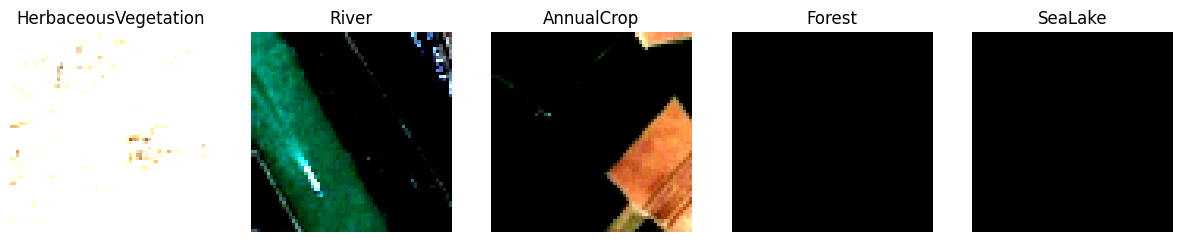

In [12]:
rand_ids = torch.randint(0, len(train_features_batch), size=[5]).tolist()

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(rand_ids):
    img, label = train_features_batch[idx], train_labels_batch[idx]

    axes[i].imshow(img.permute(1, 2, 0).numpy())
    axes[i].set_title(class_names[label])
    axes[i].axis("off")

plt.show()

### Model Initialization

#### Custom model

In [13]:
# # Create a baseline model
# class BreedIDModel(nn.Module):
#     def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
#         super().__init__()
#         self.layer_stack = nn.Sequential(nn.Flatten(),
#                                          nn.Linear(in_features=input_shape,
#                                                    out_features=hidden_units),
#                                          nn.Linear(in_features=hidden_units,
#                                                    out_features=output_shape))
#     def forward(self, x):
#         return self.layer_stack(x)

# # See what the model looks like
# h = 224
# w = 224
# c = 1
# model = BreedIDModel(input_shape=h*w*c,
#                          hidden_units=10,
#                          output_shape=len(class_names))
# model

#### EfficientNet

In [14]:
# # Load EfficientNet model
# model = torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT).to(device)

# # Parameter training setting
# for param in model.features.parameters():
#     param.requires_grad = True

# # Define classifier
# model.classifier = torch.nn.Sequential(
#     torch.nn.Linear(in_features=model.classifier[1].in_features,
#                     out_features=class_len,
#                     bias=True)
#                     ).to(device)

#### DenseNet

In [15]:
# Load DenseNet model
model = torchvision.models.densenet169(weights=torchvision.models.DenseNet169_Weights.DEFAULT).to(device)

# Parameter training setting
for param in model.features.parameters():
    param.requires_grad = True

# Define classifier
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=model.classifier.in_features,
                    out_features=class_len,
                    bias=True)
                    ).to(device)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 93.3MB/s]


#### Move model to device and inspect

In [16]:
model.to(device)
#model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Initialize Accuracy Function & Optimizer

In [17]:
# Accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Setup loss function, optimizer and scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.01)

### Define colors

In [18]:
# ANSI color codes
RED = "\033[91m"
GREEN = "\033[92m"
BLUE = "\033[94m"
YELLOW = "\033[93m"
CYAN = "\033[96m"
RESET = "\033[0m"  # Reset color

# Define color variations
MODEL_COLOR = CYAN if model._get_name == "EfficientNet" else BLUE
PARAM_COLOR = GREEN if param.requires_grad else RED
BATCH_COLOR = RED if BATCH_SIZE >= 64 else YELLOW
GPU_COLOR = GREEN if device == 'cuda' else RED

### Define logging functions

In [19]:
def clean_csv(filenames):
    for filename in filenames:
        with open(f"csv/{filename}.csv", "w"): pass

def log_csv(filename, data):
    with open(f"csv/{filename}.csv", "a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(data)

### Training

In [20]:
# Create directories for outputs
dirs = ["csv", "txt", "confusion-matrices", "roc-curves", "models"]
for dir in dirs:
    os.makedirs(dir, exist_ok=True)

# Clean csv's
clean_csv(["accuracy", "train_loss", "test_loss"])

# Print training info
print(f"TRAINING {MODEL_COLOR}{model._get_name()}{RESET}\n"
      f"PARAMETER TRAINING {PARAM_COLOR}{param.requires_grad}{RESET}\n"
      f"BATCHES OF {BATCH_COLOR}{BATCH_SIZE}{RESET}\n"
      f"ON {GPU_COLOR}{gpu}{RESET}\n")

# Set num of epochs
epochs = 10

# Training loop
for epoch in range(1, epochs+1):
    # Reset timer
    start_time = timer()

    # Reset train loss
    train_loss, best_acc = 0, 0

    # Switch to train mode
    model.train()

    # X - image, y - label
    for batch, (X, y) in enumerate(train_dataloader, start=1):
        # Move data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calc loss per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Zero grad the optimizer
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Output progress
        if batch % 10 == 0 or batch == len(train_dataloader):
            end_time = timer()
            total_time = end_time - start_time
            samples = batch * len(X)
            total_samples = len(train_dataloader.dataset)
            seconds_per_batch = total_time / batch
            eta = max(0, (len(train_dataloader) - batch) * seconds_per_batch)
            eta_h = int(eta // 3600)
            eta_m = int((eta % 3600) // 60)
            eta_s = int(eta % 60)
            print(f"{CYAN}Epoch {epoch}:{RESET} looked at {GREEN}{samples}/{total_samples}{RESET} samples "
                    f"({YELLOW}{total_time:.2f}{RESET} seconds taken, {BLUE}{seconds_per_batch:.2f}{RESET} s/batch, "
                    f"ETA: {RED}{eta_h}h{RESET} {GREEN}{eta_m}m{RESET} {BLUE}{eta_s}s{RESET})", end="\r")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    # Reset test loss and acc
    test_loss, total_samples, total_correct = 0, 0, 0
    predictions, labels = [], []
    roc_labels, roc_probabilities = [], []

    # Switch to evaluation mode
    model.eval()

    # Testing loop
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # Move data to device
            X_test, y_test = X_test.to(device), y_test.to(device)

            # 1. Forward pass
            test_pred = model(X_test)

            # Calculate ROC-curve data
            probabilities = torch.softmax(test_pred, dim=1)  # Shape: (batch_size, num_classes)
            roc_labels.extend(y_test.cpu().numpy())  # True labels
            roc_probabilities.extend(probabilities.cpu().numpy())  # Probabilities for all classes

            # 2. Calculate loss
            test_loss += loss_fn(test_pred, y_test).item()

            # 3. Count correct predictions
            correct_predictions = torch.eq(y_test, test_pred.argmax(dim=1)).sum().item()
            total_correct += correct_predictions
            total_samples += len(y_test)

            # 4. Store predictions and labels for confusion matrix
            predictions.extend(test_pred.argmax(dim=1).cpu().numpy())
            labels.extend(y_test.cpu().numpy())

        # 5. Calc test loss avg per batch
        test_loss /= len(test_dataloader)
        test_acc = (total_correct / total_samples)

    # Save best weights
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f"models/{model._get_name()}_{param.requires_grad}_{(test_acc*100):.2f}_weights.pt")

    # Update scheduler
    scheduler.step(test_loss)

    # Print & Log results
    print(f"\nTrain loss = {train_loss:.2f}\nTest loss = {test_loss:.2f}\nTest accuracy = {GREEN}{(test_acc*100):.2f}%{RESET}\n")
    log_csv("accuracy", [epoch, round(test_acc, 4)])
    log_csv("train_loss", [epoch, round(train_loss, 2)])
    log_csv("test_loss", [epoch, round(test_loss, 2)])

    # Compute confusion matrix and save it
    cm = confusion_matrix(labels, predictions)
    np.save(f"confusion-matrices/cm{epoch}.npy", cm)

    # Convert to numpy arrays and save ROC-curve data
    roc_labels = np.array(roc_labels)
    roc_probabilities = np.array(roc_probabilities)
    np.save(f"roc-curves/roc_labels{epoch}.npy", roc_labels)
    np.save(f"roc-curves/roc_probabilities{epoch}.npy", roc_probabilities)

TRAINING DenseNet
PARAMETER TRAINING True
BATCHES OF 32
ON NVIDIA GeForce RTX 4090

Epoch 1: looked at 9120/24300 samples (45.58 seconds taken, 0.06 s/batch, ETA: 0h 0m 0s)))
Train loss = 0.43
Test loss = 0.21
Test accuracy = 92.37%

Epoch 2: looked at 9120/24300 samples (44.33 seconds taken, 0.06 s/batch, ETA: 0h 0m 0s)))
Train loss = 0.22
Test loss = 0.17
Test accuracy = 95.11%

Epoch 3: looked at 9120/24300 samples (44.64 seconds taken, 0.06 s/batch, ETA: 0h 0m 0s)))
Train loss = 0.19
Test loss = 0.21
Test accuracy = 92.81%

Epoch 4: looked at 9120/24300 samples (43.88 seconds taken, 0.06 s/batch, ETA: 0h 0m 0s)))
Train loss = 0.15
Test loss = 0.09
Test accuracy = 96.89%

Epoch 5: looked at 9120/24300 samples (42.72 seconds taken, 0.06 s/batch, ETA: 0h 0m 0s)))
Train loss = 0.14
Test loss = 0.12
Test accuracy = 96.11%

Epoch 6: looked at 9120/24300 samples (43.81 seconds taken, 0.06 s/batch, ETA: 0h 0m 0s)))
Train loss = 0.14
Test loss = 0.09
Test accuracy = 96.96%

Epoch 7: looked 